# Histopathologic Cancer Detection - Week 3 Mini-Project
For this week's mini-project, you will participate in this Kaggle competition: 
Histopathologic Cancer Detection

This Kaggle competition is a binary image classification problem where you will identify metastatic cancer in small image patches taken from larger digital pathology scans.

The project has 125 total points. The instructions summarize the criteria you will use to guide your submission and review others' submissions. Note: to receive total points for this section, the learner doesn't need to have a top-performing score on the challenge. As a mini-project to complete as a weekly assignment, we don't expect you to iterate over your project until you have a model capable of winning the challenge. The iterative process takes time, so please start early to get better-quality results and reports. The learner needs to show a score that reasonably reflects that they completed the rubric parts of this project. The grades are more based on the quality and depth of the analysis, not just on a better Kaggle score.

## Project 3: Cancer Detection  
### 1.1 Module and Data Imports

*Credit to grantbrooksdev (fellow student) for inspiration to use Kaggle API*


In [2]:
import os
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
import seaborn
import numpy as np
import tensorflow as tf
print(tf.__version__)

2024-09-29 16:20:34.375492: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 16:20:34.432265: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-29 16:20:34.451094: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-29 16:20:34.508845: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-29 16:20:35.442202: W tensorflow/compiler/tf2

2.17.0


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


I0000 00:00:1727652038.385525   10930 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727652038.509214   10930 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727652038.509512   10930 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [7]:
!kaggle competitions download -c histopathologic-cancer-detection

100%|█████████████████████████████████████▉| 6.31G/6.31G [03:06<00:00, 45.7MB/s]
100%|██████████████████████████████████████| 6.31G/6.31G [03:06<00:00, 36.4MB/s]


In [5]:
if not os.path.exists("data") or not os.listdir("data"):
    print("Data directory is empty. Extracting zip file...")
    with zipfile.ZipFile("histopathologic-cancer-detection.zip", 'r') as zip_ref:
        zip_ref.extractall("data/")
    print("Extraction complete.")
else:
    print("Data directory is not empty. Skipping extraction.")

Data directory is not empty. Skipping extraction.


In [6]:
# Specify the directory path
data_dir = 'data'
test_set_dir = 'data/test'
train_set_dir = 'data/train'

# Get the list of files and directories
contents = os.listdir(data_dir)

print("Data Directory Contents:")
for item in contents:
    print("| - " +item)

num_training_samples = len(os.listdir(train_set_dir))
num_testing_samples = len(os.listdir(test_set_dir))
print(f"Number of training samples: {num_training_samples}")
print(f"Number of testing samples: {num_testing_samples}")

Data Directory Contents:
| - train
| - sample_submission.csv
| - test
| - train_labels.csv
Number of training samples: 220025
Number of testing samples: 57458


### 1.2 EDA  
EDA strategy: We already know the size of the set of training and test data we have available, but we do not yet know anything of the nature of the image data. Since we are dealing with images, we probably want to know the shape of the images and do some analysis of the color values.  
1. We should first like to assert that the training and test data is similiar in color distribution. If they are not, we aren't going to get very far.  
2. We should take a look at some images. It is important for the modeller to get an intuitive understanding of the data and see if there are any apparent features to guide the model towards. 
3. We should get an idea of the color deviations between tumor and non tumor images. Since this is the only difference we really have to work with, we should see the deviance between the two.

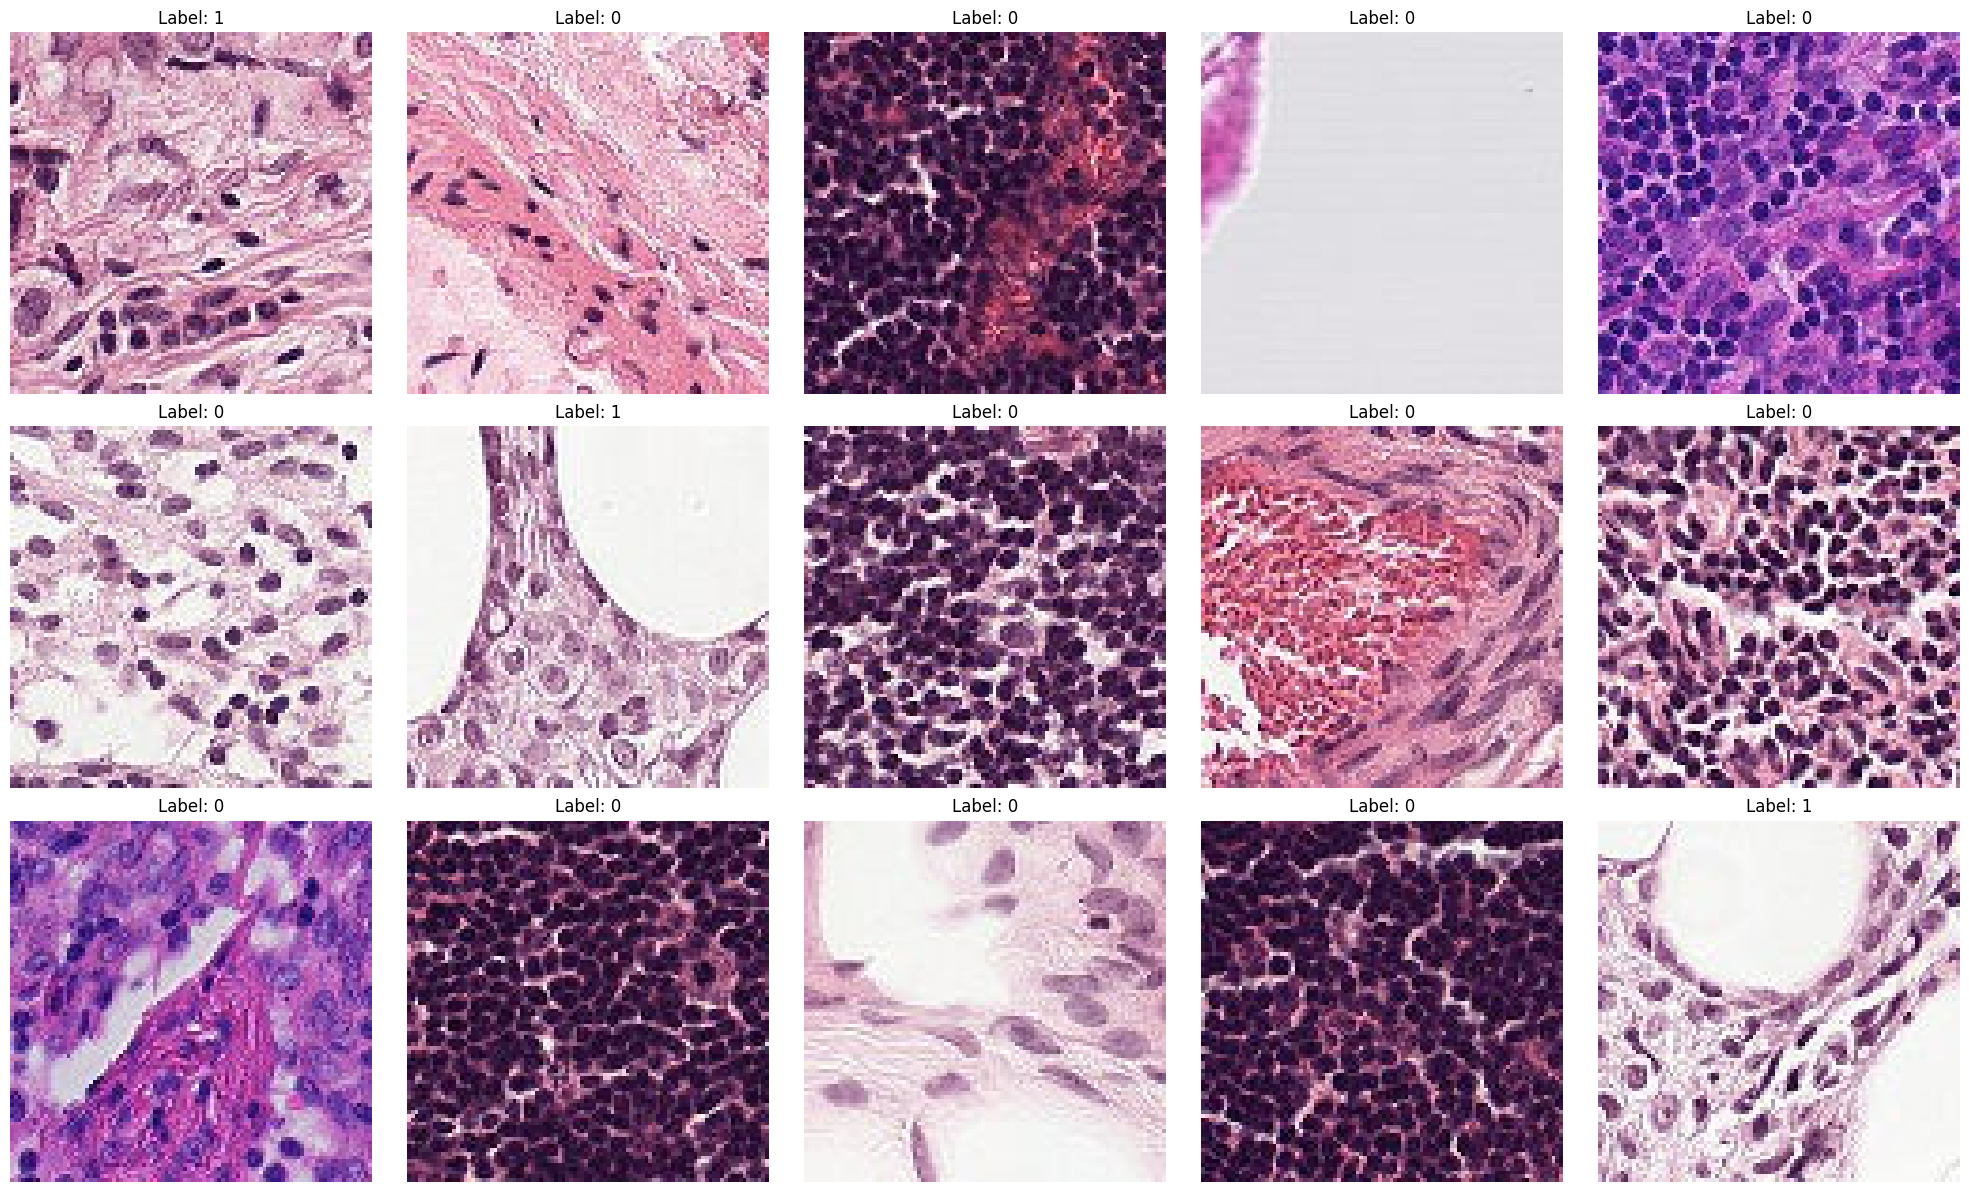

Image shape: (96, 96, 3)


In [13]:
def load_single_image(data_path):
    for filename in os.listdir(data_path):
        if filename.endswith('.tif'):
            img_path = os.path.join(data_path, filename)
            img = Image.open(img_path)
            img_array = np.array(img)
            return img_array
    return None

# Load a single image from the test directory
test_image = load_single_image(test_set_dir)
IMAGE_SHAPE = test_image.shape

def load_first_n_images_with_labels(data_path, labels_df, n=5):
    images = []
    labels = []
    for filename in os.listdir(data_path)[:n]:
        if filename.endswith('.tif'):
            img_path = os.path.join(data_path, filename)
            img = Image.open(img_path)
            img_array = np.array(img)
            images.append(img_array)
            
            if labels_df is not None:
                # Get the corresponding label
                image_id = filename.split('.')[0]
                label = labels_df.loc[labels_df['id'] == image_id, 'label'].values[0]
                labels.append(label)
    
    return np.array(images), labels

# Load the first n images from the test directory
n = 15
train_labels = pd.read_csv("data/train_labels.csv")
sample_images, sample_labels = load_first_n_images_with_labels(train_set_dir, train_labels, n)

# Display the images in three rows
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
for i, ax in enumerate(axes.flat):
    if i < len(sample_images):
        ax.imshow(sample_images[i])
        ax.axis('off')
        ax.set_title(f'Label: {sample_labels[i]}')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

if test_image is not None:
    print(f"Image shape: {IMAGE_SHAPE}")

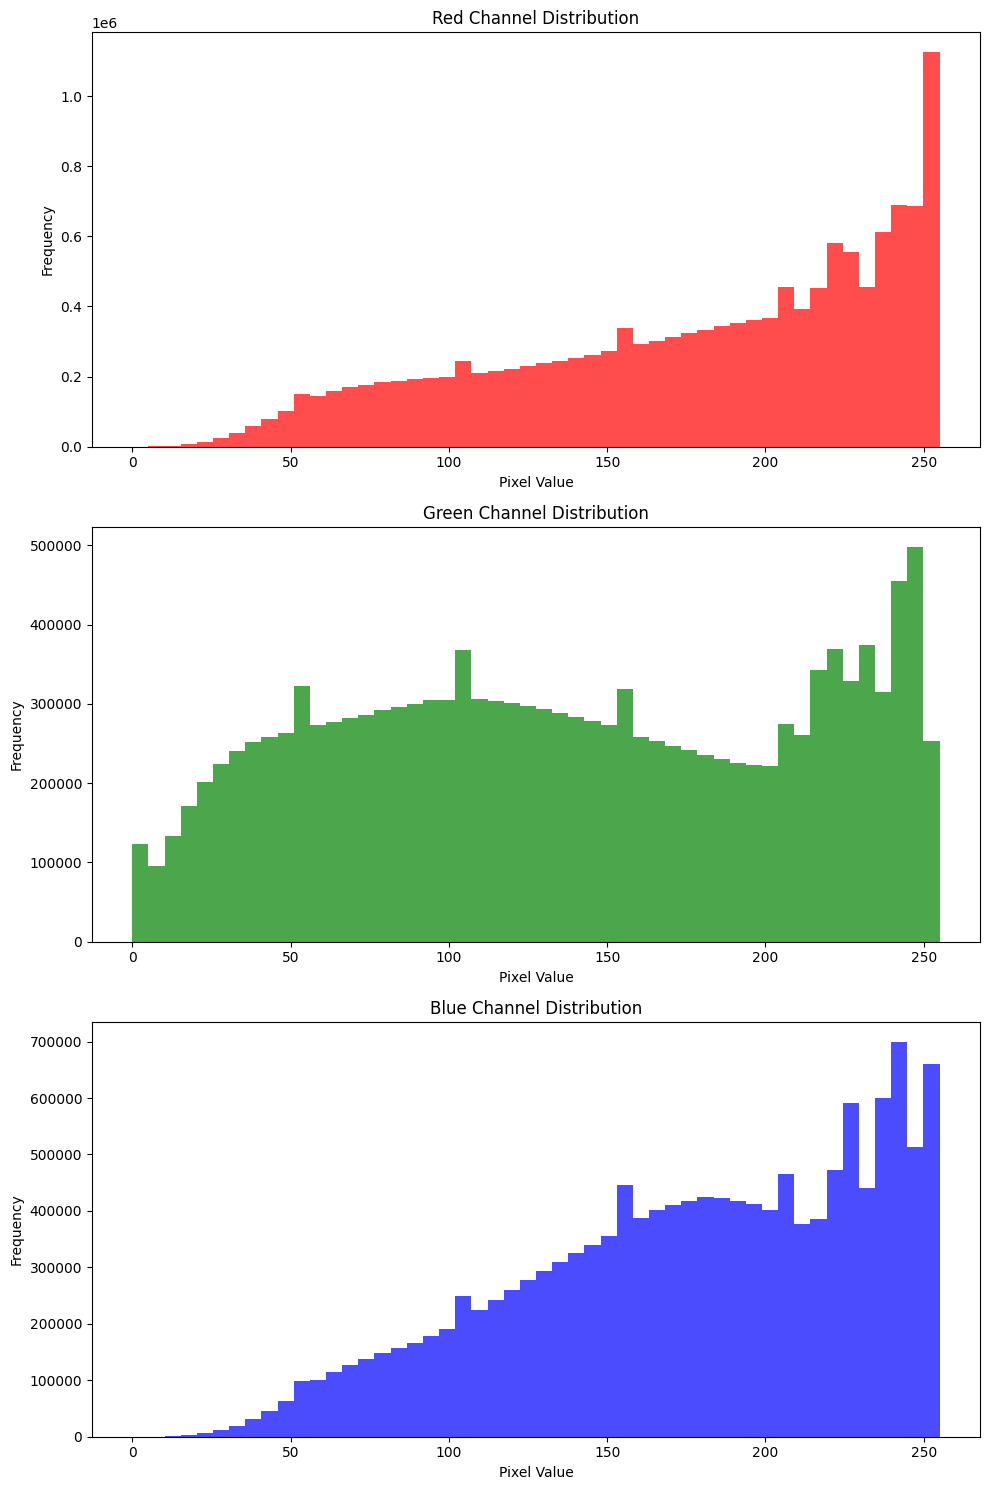

Average Red channel intensity: 177.85
Average Green channel intensity: 137.30
Average Blue channel intensity: 176.37


In [14]:
sample_images, labels = load_first_n_images_with_labels(train_set_dir, train_labels, 1500)
# Analyze color channels
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
channel_names = ['Red', 'Green', 'Blue']

for i, channel in enumerate(range(3)):
    channel_values = sample_images[:, :, :, channel].flatten()
    axes[i].hist(channel_values, bins=50, color=channel_names[i].lower(), alpha=0.7)
    axes[i].set_title(f'{channel_names[i]} Channel Distribution')
    axes[i].set_xlabel('Pixel Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print average channel intensities
avg_intensities = np.mean(sample_images, axis=(0, 1, 2))
for channel, intensity in zip(channel_names, avg_intensities):
    print(f"Average {channel} channel intensity: {intensity:.2f}")

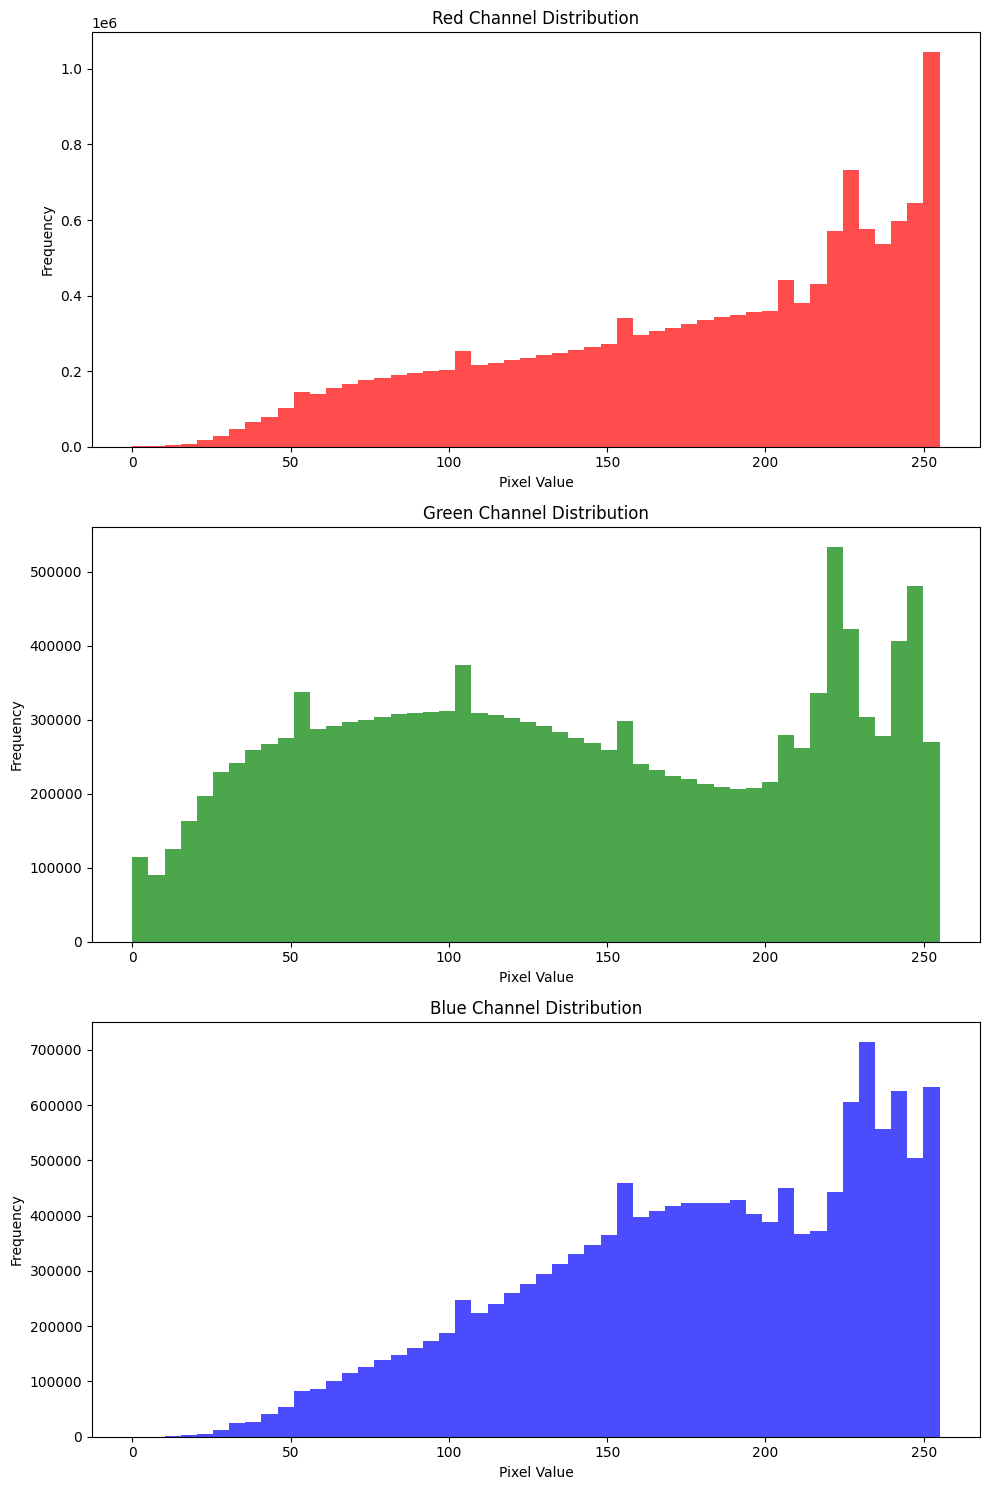

Average Red channel intensity: 177.01
Average Green channel intensity: 136.76
Average Blue channel intensity: 177.41


In [17]:
sample_images, labels = load_first_n_images_with_labels(test_set_dir, None, 1500)
# Analyze color channels
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
channel_names = ['Red', 'Green', 'Blue']

for i, channel in enumerate(range(3)):
    channel_values = sample_images[:, :, :, channel].flatten()
    axes[i].hist(channel_values, bins=50, color=channel_names[i].lower(), alpha=0.7)
    axes[i].set_title(f'{channel_names[i]} Channel Distribution')
    axes[i].set_xlabel('Pixel Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print average channel intensities
avg_intensities = np.mean(sample_images, axis=(0, 1, 2))
for channel, intensity in zip(channel_names, avg_intensities):
    print(f"Average {channel} channel intensity: {intensity:.2f}")

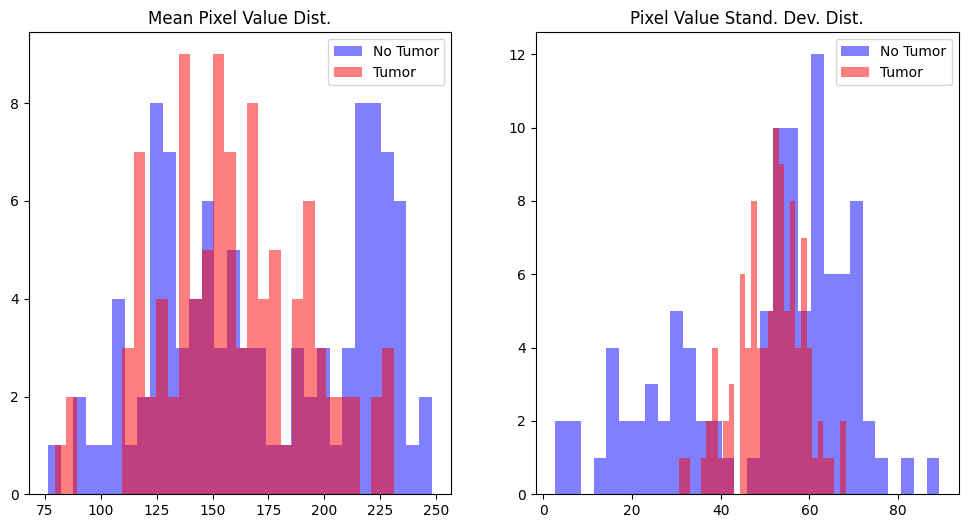

In [18]:

def image_stats(image_ids):
    means, stds = [], []
    for img_id in image_ids:
        img = np.array(Image.open(f'data/train/{img_id}.tif'))
        means.append(np.mean(img))
        stds.append(np.std(img))
    return means, stds

benign_ids = train_labels[train_labels['label'] == 0]['id'].sample(100)
tumor_ids = train_labels[train_labels['label'] == 1]['id'].sample(100)

benign_means, benign_stds = image_stats(benign_ids)
tumor_means, tumor_stds = image_stats(tumor_ids)

plt.figure(figsize=(12, 6))

# overlay the mean pixel value distributions of the images of each class

plt.subplot(1, 2, 1)
plt.hist(benign_means, alpha=0.5, color='blue', bins=30, label='No Tumor')
plt.hist(tumor_means, alpha=0.5, color='red', bins=30, label='Tumor')
plt.title('Mean Pixel Value Dist.')
plt.legend()


# overlay the mean pixel value standard distribution of the images of each class

plt.subplot(1, 2, 2)
plt.hist(benign_stds, alpha=0.5, color='blue', bins=30, label='No Tumor')
plt.hist(tumor_stds, alpha=0.5, color='red', bins=30, label='Tumor')
plt.title('Pixel Value Stand. Dev. Dist.')
plt.legend()

plt.show()

### 1.2 Model Formulation
We will use two different models and analyze the hyperparameters between them.
To recall the key hyperparamters for CNN:  
- Number of convolutional layers
- Number of filters
- Size of filters
- Activation function
- Pooling size
- Optimizer
- Loss function

We are going to start with a simple model and then add one with more depth to compare. 

In [19]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(
    train_labels,
    test_size=0.2,
    stratify=train_labels['label'],
    random_state=29
)

print(f"Training size: {len(train)}")
print(f"Validation size: {len(val)}")

# transform data into format that tensorflow can interpret and work with
train_dataset = tf.data.Dataset.from_tensor_slices((train['id'].values, train['label'].values))
val_dataset = tf.data.Dataset.from_tensor_slices((val['id'].values, val['label'].values))

# function for preprocessing images including a line to shrink the images a bit to improve training speed
def preprocess_image(path, label):
    full_path = tf.strings.join(['data/train/', path, '.tif'])
    image = tf.py_function(load_tif, [full_path], tf.float32)
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0

    label = tf.cast(label, tf.float32)
    return image, label

def load_tif(path):
    image = Image.open(path.numpy().decode('utf-8'))
    image = image.convert('RGB')
    image_arr = np.array(image).astype(np.float32)
    return image_arr

batch_size = 32
buffer_size = 10000


# preprocess training images and shuffle training set
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=buffer_size).batch(batch_size).prefetch(buffer_size=buffer_size)

# preprocess validation images
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=10000)

Training size: 176020
Validation size: 44005


I0000 00:00:1727652345.128344   10930 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727652345.128647   10930 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727652345.128848   10930 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727652345.226973   10930 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [23]:
# Create a basic model with a single layer
simple_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

# Compile the model
simple_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_baseline = simple_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    batch_size=64
)

# Evaluate the model
test_loss, test_accuracy = simple_model.evaluate(val_dataset)
print(f"Test accuracy: {test_accuracy:.4f}")

Epoch 1/10


/home/drodriq/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-29 16:58:56.865133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 3875 of 10000
2024-09-29 16:59:06.869819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 7736 of 10000
2024-09-29 16:59:12.603950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 607s 105ms/step - accuracy: 0.7835 - loss: 0.4648 - val_accuracy: 0.8503 - val_loss: 0.3520
Epoch 2/10


2024-09-29 17:09:02.808393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 3908 of 10000
2024-09-29 17:09:12.812364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 7854 of 10000


   2/5501 ━━━━━━━━━━━━━━━━━━━━ 6:58 76ms/step - accuracy: 0.9062 - loss: 0.3180   

2024-09-29 17:09:18.363216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 598s 104ms/step - accuracy: 0.8455 - loss: 0.3560 - val_accuracy: 0.8585 - val_loss: 0.3276
Epoch 3/10


2024-09-29 17:19:01.144233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 4045 of 10000
2024-09-29 17:19:11.152950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 8043 of 10000


   1/5501 ━━━━━━━━━━━━━━━━━━━━ 38:10:26 25s/step - accuracy: 0.9688 - loss: 0.1910

2024-09-29 17:19:16.015589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 594s 104ms/step - accuracy: 0.8644 - loss: 0.3203 - val_accuracy: 0.8684 - val_loss: 0.3122
Epoch 4/10


2024-09-29 17:28:55.594133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 4806 of 10000


   2/5501 ━━━━━━━━━━━━━━━━━━━━ 9:16 101ms/step - accuracy: 0.8906 - loss: 0.2733  

2024-09-29 17:29:07.989930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 574s 100ms/step - accuracy: 0.8752 - loss: 0.2956 - val_accuracy: 0.8693 - val_loss: 0.3091
Epoch 5/10


2024-09-29 17:38:29.638655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 4057 of 10000


   2/5501 ━━━━━━━━━━━━━━━━━━━━ 9:18 102ms/step - accuracy: 0.8906 - loss: 0.3363  

2024-09-29 17:38:44.311065: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 594s 103ms/step - accuracy: 0.8870 - loss: 0.2723 - val_accuracy: 0.8694 - val_loss: 0.3112
Epoch 6/10


2024-09-29 17:48:23.493613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 4082 of 10000


   2/5501 ━━━━━━━━━━━━━━━━━━━━ 6:26 70ms/step - accuracy: 0.9141 - loss: 0.1977   

2024-09-29 17:48:38.208236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 595s 104ms/step - accuracy: 0.9008 - loss: 0.2415 - val_accuracy: 0.8639 - val_loss: 0.3314
Epoch 7/10


2024-09-29 17:58:18.853828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 3997 of 10000
2024-09-29 17:58:28.867362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 8023 of 10000


   1/5501 ━━━━━━━━━━━━━━━━━━━━ 38:19:18 25s/step - accuracy: 0.8125 - loss: 0.2958

2024-09-29 17:58:33.829646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 598s 104ms/step - accuracy: 0.9161 - loss: 0.2070 - val_accuracy: 0.8648 - val_loss: 0.3745
Epoch 8/10


2024-09-29 18:08:17.053351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 4035 of 10000


   1/5501 ━━━━━━━━━━━━━━━━━━━━ 37:35:36 25s/step - accuracy: 0.8750 - loss: 0.3956

2024-09-29 18:08:31.537773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 599s 104ms/step - accuracy: 0.9342 - loss: 0.1688 - val_accuracy: 0.8585 - val_loss: 0.4136
Epoch 9/10


2024-09-29 18:18:16.256595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 4025 of 10000


   2/5501 ━━━━━━━━━━━━━━━━━━━━ 9:10 100ms/step - accuracy: 0.9688 - loss: 0.1357  

2024-09-29 18:18:30.825437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 600s 105ms/step - accuracy: 0.9492 - loss: 0.1331 - val_accuracy: 0.8544 - val_loss: 0.4830
Epoch 10/10


2024-09-29 18:28:16.665640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 4257 of 10000
2024-09-29 18:28:26.670201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 8638 of 10000


   1/5501 ━━━━━━━━━━━━━━━━━━━━ 35:45:44 23s/step - accuracy: 0.8750 - loss: 0.3083

2024-09-29 18:28:29.962883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 590s 103ms/step - accuracy: 0.9629 - loss: 0.1009 - val_accuracy: 0.8521 - val_loss: 0.5889
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 117s 85ms/step - accuracy: 0.8530 - loss: 0.5807
Test accuracy: 0.8521


In [24]:
simple_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,875,845 (18.60 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,250,564 (12.40 MB)

In [28]:
deeper_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),  # Additional conv layer
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),  # First dropout layer
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Second dropout layer
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

deeper_model.summary()

deeper_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Train the model
history_dropout = simple_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=8,
    batch_size=64
)


Epoch 1/8


2024-09-29 20:03:42.896250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 3928 of 10000
2024-09-29 20:03:52.907268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 7842 of 10000


   2/5501 ━━━━━━━━━━━━━━━━━━━━ 8:19 91ms/step - accuracy: 0.9766 - loss: 0.0488   

2024-09-29 20:03:58.442174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 598s 104ms/step - accuracy: 0.9900 - loss: 0.0299 - val_accuracy: 0.8387 - val_loss: 1.0978
Epoch 2/8


2024-09-29 20:13:40.500938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 3841 of 10000


   2/5501 ━━━━━━━━━━━━━━━━━━━━ 6:01 66ms/step - accuracy: 0.9766 - loss: 0.0247   

2024-09-29 20:13:56.413487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 598s 104ms/step - accuracy: 0.9911 - loss: 0.0271 - val_accuracy: 0.8478 - val_loss: 1.1027
Epoch 3/8


2024-09-29 20:23:38.188935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 4064 of 10000
2024-09-29 20:23:48.204416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 8158 of 10000


   2/5501 ━━━━━━━━━━━━━━━━━━━━ 7:39 84ms/step - accuracy: 1.0000 - loss: 0.0218   

2024-09-29 20:23:52.718204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 587s 102ms/step - accuracy: 0.9917 - loss: 0.0257 - val_accuracy: 0.8443 - val_loss: 1.1956
Epoch 4/8


2024-09-29 20:33:24.925651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 4077 of 10000


   1/5501 ━━━━━━━━━━━━━━━━━━━━ 37:39:03 25s/step - accuracy: 1.0000 - loss: 3.2308e-04

2024-09-29 20:33:39.468695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 602s 105ms/step - accuracy: 0.9915 - loss: 0.0267 - val_accuracy: 0.8452 - val_loss: 1.2263
Epoch 5/8


2024-09-29 20:43:26.515210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 4037 of 10000


   1/5501 ━━━━━━━━━━━━━━━━━━━━ 37:59:26 25s/step - accuracy: 1.0000 - loss: 5.4407e-04

2024-09-29 20:43:41.278485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 604s 105ms/step - accuracy: 0.9922 - loss: 0.0247 - val_accuracy: 0.8431 - val_loss: 1.2115
Epoch 6/8


2024-09-29 20:53:30.010684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 4058 of 10000
2024-09-29 20:53:40.032592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 8183 of 10000


   2/5501 ━━━━━━━━━━━━━━━━━━━━ 7:36 83ms/step - accuracy: 1.0000 - loss: 0.0179   

2024-09-29 20:53:44.459434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 592s 103ms/step - accuracy: 0.9925 - loss: 0.0239 - val_accuracy: 0.8429 - val_loss: 1.2282
Epoch 7/8


2024-09-29 21:03:21.531249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 3955 of 10000


   2/5501 ━━━━━━━━━━━━━━━━━━━━ 7:39 84ms/step - accuracy: 0.9844 - loss: 0.0507   

2024-09-29 21:03:36.984025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 610s 106ms/step - accuracy: 0.9929 - loss: 0.0236 - val_accuracy: 0.8405 - val_loss: 1.1808
Epoch 8/8


2024-09-29 21:13:31.366604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 4066 of 10000
2024-09-29 21:13:41.375408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 8009 of 10000


   2/5501 ━━━━━━━━━━━━━━━━━━━━ 8:18 91ms/step - accuracy: 0.9766 - loss: 0.0268   

2024-09-29 21:13:46.321683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 610s 106ms/step - accuracy: 0.9930 - loss: 0.0216 - val_accuracy: 0.8420 - val_loss: 1.2180


In [30]:
# Evaluate the model
test_loss, test_accuracy = deeper_model.evaluate(val_dataset)
print(f"Test accuracy: {test_accuracy:.4f}")

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 119s 85ms/step - accuracy: 0.4057 - loss: 0.7153
Test accuracy: 0.4050


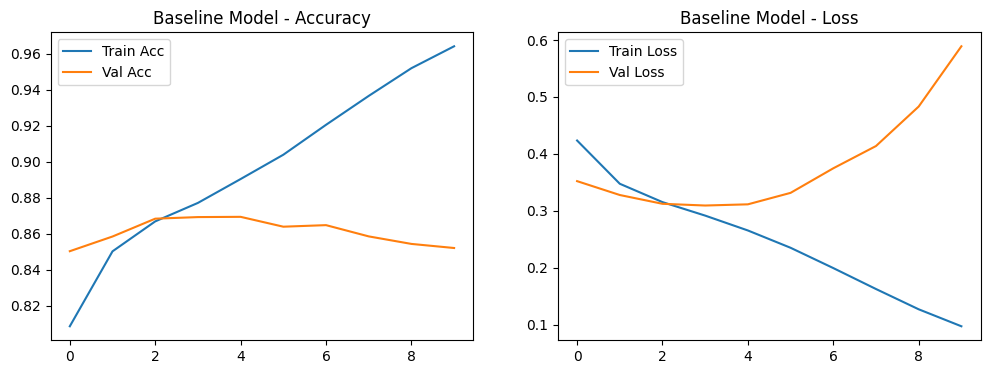

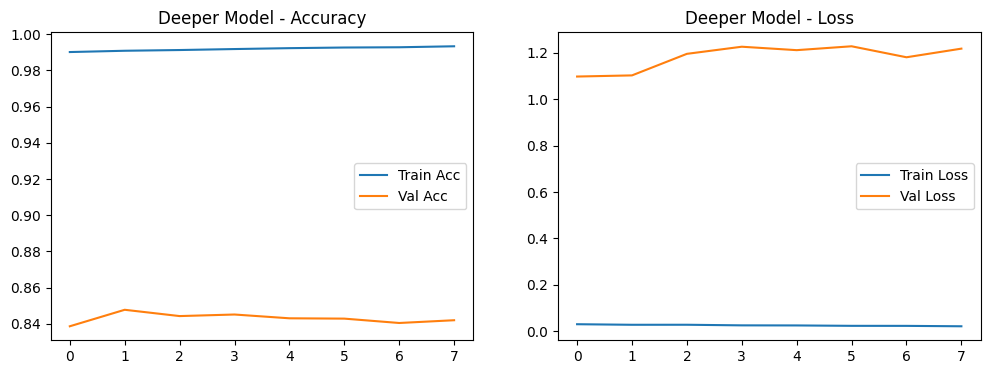

In [31]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

plot_history(history_baseline, 'Baseline Model')
plot_history(history_dropout, 'Dropout Model')

In [32]:
test_images = []
test_filenames = []

for filename in os.listdir(test_set_dir):
    if filename.endswith('.tif'):
        img_path = os.path.join(test_set_dir, filename)
        img = Image.open(img_path)
        img_array = np.array(img)
        test_images.append(img_array)
        test_filenames.append(filename.split('.')[0])

test_images = np.array(test_images).astype(np.float32)

# Generate predictions
predictions = deeper_model.predict(test_images)
predictions = (predictions > 0.5).astype(int).flatten()

# Create DataFrame with results
results_df = pd.DataFrame({
    'id': test_filenames,
    'label': predictions
})

# Save to CSV
results_df.to_csv('test_predictions.csv', index=False)

print("Predictions saved to predictions.csv")

: 

## Conclusion
The simple model was able to learn and achieve a fairly decent accuracy on training set, but as the loss plot and the performance on the validation set shows, the model was overfitting local training data and not generalizing well. By epoch 10 the loss started to rise again. Validation accuracy plateaued and then declined. I would guess it would perform poorly on the test data. 

The dropout model with more layers but less parameters was able to train quickly and overfit the data. 

The submission screenshot shows a model trained earlier but unfortunately the work was lost from it. I leave the rest of this notebook as a reference. 